# VAE

In [1]:
import torch
import torch.utils.data
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils import data as D

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from torchsummary import summary
from time import time
from datetime import datetime
import visdom

from PIL import Image
import hiddenlayer as hl

from apex import amp

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") # Should be true

True


# Load Data

In [3]:
path = ['../data/anime-faces-opencv/data', '../data/danbooru-faces-64', '../data/danbooru-faces-exact-64'][2]
image_size = 64
batch_size = 64

In [4]:
def show_batch(trainloader):
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        plt.figure(figsize=(16,8))
        plt.imshow(npimg)
        plt.show()
        
    dataiter = iter(trainloader)
    images = dataiter.next()

    imshow(torchvision.utils.make_grid(images[:32], nrow=16))

In [5]:
class AnimeDataset(D.Dataset):
    """Anime Dataset"""

    def __init__(self, path, transform=transforms.Compose([transforms.ToTensor()
                                                           ])):
        """
        Args:
            patj (string): Path to the folder
        """
        self.path = path
        self.transform = transform
        self.list_IDs = self.fetch()
        
    def fetch(self):
        return glob.glob(os.path.join(path, '*/*.jpg'))
        return list(os.listdir(path))

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, idx):
        img_name = self.list_IDs[idx]
        
        image = np.array(Image.open(img_name), dtype='float32')
        image = np.transpose(image, (2, 0, 1))
        image = (image / 255.) * 2. - 1.
        
        if self.transform:
            sample = self.transform(image)
        return image

In [6]:
def get_data(path, batch_size=64, num_workers=6, shuffle=True, test=0.2):
    #data = datasets.ImageFolder(path, transform=transforms.ToTensor())
    data = AnimeDataset(path)
    
    len_test = int(len(data)*test)
    len_train = len(data) - len_test
    
    data_train, data_test = D.random_split(data, [len_train, len_test])
    
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                        shuffle=shuffle, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                        shuffle=shuffle, num_workers=num_workers)
    print(f"Training on {len_train} samples and testing on {len_test} samples")
    return train_loader, test_loader

In [7]:
def clean(path):
    i = 0
    for file in glob.glob(path + '/*/.*', recursive=True):
        os.remove(file)
        i+=1
    print(f"Deleted Files: {i}")

In [8]:
clean(path)

Deleted Files: 0


In [9]:
train_loader, test_loader = get_data(path, batch_size, test=0.2)

Training on 75973 samples and testing on 18993 samples


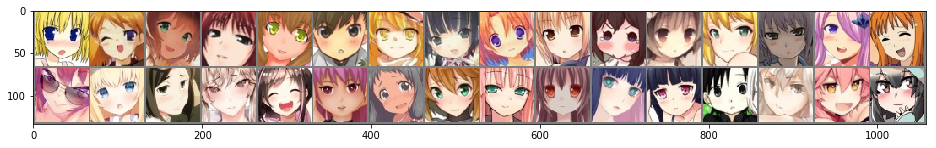

In [10]:
show_batch(train_loader)

# Define Network

In [41]:
encoder_width = 64
decoder_width = 64
latent_dim = 512

In [42]:
def conv_block(in_f, out_f, padding=0):
    return nn.Sequential(nn.Conv2d(in_f, out_f, 5, stride=2, padding=padding),
                         #nn.ReLU(),
                         nn.BatchNorm2d(out_f),
                         nn.ReLU())
def deconv_block(in_f, out_f, padding=0):
    return nn.Sequential(nn.ConvTranspose2d(in_f, out_f, 6, stride=2, padding=padding),
                         #nn.ReLU(),
                         nn.BatchNorm2d(out_f),
                         nn.ReLU())

In [43]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Params
        ew = encoder_width
        dw = decoder_width
        self.dw = dw
        
        self.block1 = conv_block(3, ew, padding=2)
        self.block2 = conv_block(ew, ew*2, padding=2)
        self.block3 = conv_block(ew*2, ew*4, padding=2)
        self.block4 = conv_block(ew*4, ew*8, padding=2)
        
        self.block5 = nn.Sequential(nn.Linear(ew*8*(image_size//16)**2, latent_dim*2),
                                    nn.BatchNorm1d(latent_dim*2))
        
        self.fc1    = nn.Linear(latent_dim, dw*4*(image_size//8)**2)
        self.block6 = nn.Sequential(nn.BatchNorm2d(dw*4),
                                    nn.ReLU())
        
        self.block7 = deconv_block(dw*4, dw*4, padding=2)
        self.block8 = deconv_block(dw*4, dw*2, padding=2)
        self.block9 = deconv_block(dw*2, dw//2, padding=2)
        
        self.dc1 = nn.ConvTranspose2d(dw//2, 3, 5, padding=2)
    
    def encoder(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(-1, x.shape[1] * x.shape[2] *x.shape[3])
        x = self.block5(x)
        return x

    def draw_random(self, z):
        mean = z[:, :latent_dim]
        logvar = z[:, latent_dim:]
        
        std = torch.sqrt(torch.exp(logvar))
        epsilon = torch.FloatTensor(std.size()).normal_().to(device)
        epsilon = Variable(epsilon)
        
        x = epsilon.mul(std).add_(mean)
        return x, mean, std

    def decoder(self, x):
        
        # forward pass
        x = self.fc1(x)
        x = x.view(-1, self.dw*4, (image_size//8), (image_size//8))
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.dc1(x)
        x = torch.tanh(x)
        return x

    def forward(self, x):
        latent_mean_logvar = self.encoder(x)
        latent_code, latent_mean, latent_std = self.draw_random(latent_mean_logvar)
        generated = self.decoder(latent_code)
        return generated, latent_mean, latent_std


In [44]:
model = VAE().to(device)
#model = torch.load('../weights/725_637').to(device)
summary(model, input_size=(3, image_size, image_size), 
        device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         204,928
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         819,456
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       3,277,312
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
             ReLU-12            [-1, 512, 4, 4]               0
           Linear-13                 [-1, 1024]       8,389,632
      BatchNorm1d-14                 [-

# Train Network

In [47]:
learning_rate = 1e-3
num_epochs = 20
chunks = 2
loglevel = 3
balance_gll = 2 # more means less exact 0.0002

In [48]:
class Visualizations:
    def __init__(self, env_name=None):
        if env_name is None:
            env_name = str(datetime.now().strftime("%d-%m %Hh%M"))
        self.env_name = env_name
        self.vis = visdom.Visdom(env=self.env_name)
        self.loss_win = None

    def plot_loss(self, testloss, trainloss, epoch):
        self.loss_win = self.vis.line(
            [[testloss, trainloss]],
            [epoch],
            win=self.loss_win,
            update='append' if self.loss_win else None,
            opts=dict(
                xlabel='epoch',
                ylabel='Loss',
                title='Loss',
                legend=['Test', 'Train']
            )
        )
    
    def plot_samples(self, sample, reconstruction, index):
        
        images = torch.cat([sample[:16], reconstruction[:4], reconstruction[8:12], 
                            reconstruction[4:8], reconstruction[12:16]])
        images = (images / 2 + 0.5)*255
        self.vis.images(images, nrow=4, opts=dict(
                title='Random Generated Samples '+ index,
            ))
    
    def plot_reconstruction(self, sample, epoch):
        self.vis.images(sample, nrow=8, opts=dict(
                title='Epoch '+str(epoch) + '(Generated + Reconstructed)',
            ))

In [49]:
def loss_function(x_mean, l_mean, l_std, x):
    #BCE = F.binary_cross_entropy(recon_x.view(-1,n), x.view(-1,n), reduction='sum')
    #BCE = 0.5 * torch.sum(torch.pow(x - x_mean, 2)) / (2*observation_std**2) + torch.log(torch.tensor(observation_std))
    BCE = 0.5 * torch.sum(torch.pow(x - x_mean, 2))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = 0.5 * torch.sum(l_std.pow(2) + l_mean.pow(2) - 1. - torch.log(l_std.pow(2)))
    return (BCE + balance_gll* KLD)

In [50]:
def train(epoch, optimizer, vis):
    start = time()
    model.train()
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader):

        if data.shape[0] != batch_size: continue  
        data = data.to(device)
        optimizer.zero_grad()
        
        x_mean, latent_mean, latent_std = model(data)
        loss = loss_function(x_mean, latent_mean, latent_std, data)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if loglevel >= 2 and batch_idx % (len(train_loader)//chunks)==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
        if loglevel >= 3 and batch_idx % (len(train_loader)//chunks)==0:
            evaluate_to_vis(epoch, vis, 100. * batch_idx / len(train_loader))
            pass
    
    train_loss /= len(train_loader.dataset)
    if loglevel >= 1: print('====> Epoch: {} Average loss: {:.4f}  Duration: {:.1f} min.'.format(
    epoch, train_loss, (time() - start)/60))
    return train_loss

In [51]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data) in enumerate(test_loader):
            if data.shape[0] != batch_size: continue
            data = data.to(device)
            x_mean, latent_mean, latent_std = model(data)
            test_loss += loss_function(x_mean, latent_mean, latent_std, data).item()

    test_loss /= len(test_loader.dataset)
    if loglevel >= 0: print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [52]:
def reconstruct(epoch, loader):
    model.eval()
    with torch.no_grad():
        for i, (data) in enumerate(loader):
            if data.shape[0] != batch_size: continue
            data = data.to(device)
            generated, latent_mean, latent_std = model(data)
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  generated.view(batch_size, 3, image_size, image_size)[:n]])
            save_image(comparison.cpu(),
                     '../results/reconstruction_' + str(epoch) + '.png', nrow=n)
            return comparison.cpu()

In [53]:
def evaluate_to_vis(epoch, vis, percentage):
    reconstruction = reconstruct(epoch, test_loader)
    
    index = str(epoch) + '.' + str(np.round(percentage))
    
    with torch.no_grad():
            sample = torch.randn(batch_size, latent_dim).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample, '../results/random_sample_' + str(index) + '.png')
            
    vis.plot_samples(sample, reconstruction, index)
    model.train()

In [54]:
def fit(epochs, learning_rate, start=0, name=datetime.now().strftime("../weights/%d-%m %Hh%M"), vis=None):
    ### Optimizer
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    ### Save best
    best_loss = 1e12
    
    ### Visualize
    if vis==None:
        vis = Visualizations()
    
    for epoch in range(start, epochs):
        train_loss = train(epoch, optimizer, vis)
        test_loss = test(epoch)
        reconstruction = reconstruct(epoch, test_loader)
        
        # Save best
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model, name)
            
        # Random Sample    
        with torch.no_grad():
            sample = torch.randn(batch_size, latent_dim).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample, '../results/random_sample_' + str(epoch) + '.png')
            
        # Visualize
        vis.plot_loss(test_loss, train_loss, epoch)
        vis.plot_samples(sample, reconstruction, str(epoch))
        
    return vis

In [55]:
vis = fit(40, 1e-4, start=0)

Train Epoch: 0 [0/75973 (0%)]	Loss: 3389.123291
Train Epoch: 0 [38016/75973 (50%)]	Loss: 861.721313
====> Epoch: 0 Average loss: 944.5800  Duration: 1.7 min.
====> Test set loss: 805.6748
Train Epoch: 1 [0/75973 (0%)]	Loss: 824.316284
Train Epoch: 1 [38016/75973 (50%)]	Loss: 741.294861
====> Epoch: 1 Average loss: 787.9270  Duration: 1.6 min.
====> Test set loss: 758.9088
Train Epoch: 2 [0/75973 (0%)]	Loss: 818.216064
Train Epoch: 2 [38016/75973 (50%)]	Loss: 792.741089
====> Epoch: 2 Average loss: 752.4413  Duration: 1.6 min.
====> Test set loss: 730.0220
Train Epoch: 3 [0/75973 (0%)]	Loss: 719.958618
Train Epoch: 3 [38016/75973 (50%)]	Loss: 767.577881
====> Epoch: 3 Average loss: 727.0017  Duration: 1.6 min.
====> Test set loss: 709.3391
Train Epoch: 4 [0/75973 (0%)]	Loss: 728.799316
Train Epoch: 4 [38016/75973 (50%)]	Loss: 689.668640
====> Epoch: 4 Average loss: 711.4188  Duration: 1.6 min.
====> Test set loss: 691.4138
Train Epoch: 5 [0/75973 (0%)]	Loss: 710.601196
Train Epoch: 5 [3

In [39]:
fit(15, 3e-5, start=10, vis=vis)

Train Epoch: 10 [0/75973 (0%)]	Loss: 626.627563
Train Epoch: 10 [15168/75973 (20%)]	Loss: 629.865967
Train Epoch: 10 [30336/75973 (40%)]	Loss: 624.988403
Train Epoch: 10 [45504/75973 (60%)]	Loss: 634.489868
Train Epoch: 10 [60672/75973 (80%)]	Loss: 635.449829
Train Epoch: 10 [75840/75973 (100%)]	Loss: 634.514526
====> Epoch: 10 Average loss: 637.3108  Duration: 1.7 min.
====> Test set loss: 619.9409
Train Epoch: 11 [0/75973 (0%)]	Loss: 610.612854
Train Epoch: 11 [15168/75973 (20%)]	Loss: 656.385376
Train Epoch: 11 [30336/75973 (40%)]	Loss: 643.195251
Train Epoch: 11 [45504/75973 (60%)]	Loss: 614.989685
Train Epoch: 11 [60672/75973 (80%)]	Loss: 636.224426
Train Epoch: 11 [75840/75973 (100%)]	Loss: 634.656982
====> Epoch: 11 Average loss: 636.3655  Duration: 1.7 min.
====> Test set loss: 619.1198
Train Epoch: 12 [0/75973 (0%)]	Loss: 661.109131
Train Epoch: 12 [15168/75973 (20%)]	Loss: 659.379028
Train Epoch: 12 [30336/75973 (40%)]	Loss: 603.613586
Train Epoch: 12 [45504/75973 (60%)]	Loss

KeyboardInterrupt: 

In [56]:
torch.save(model, '../weights/512_40e')

- compare to the other
- get more data
- clean the data with this model
- find space vectors
- make sure the random samples are between -1 and 1